In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, MaxPool2D, Conv2D, BatchNormalization, Flatten,Dropout, MaxPooling2D,UpSampling2D
from keras.models import Model, load_model
from keras import regularizers, models
from keras.callbacks import EarlyStopping
from scipy.io import loadmat
import json
import numpy as np
import time

In [2]:
#функция подготовки данных
def pre_process(data):
    return data/255

#функция отображения потерь
def plot_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#функция отображения изображений сета
def plot_images(images, images_label):
  plt.figure(figsize=(20,20))
  plt.subplots_adjust(hspace=0.4)

  labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

  for i in range(100):

      plt.subplot(10,10,i+1)
      plt.imshow(images[i],cmap='Blues')
      plt.title(labels[int(images_label[i])],fontsize=12)
      plt.axis('off')

  plt.show()

In [3]:
#загружаем сет с вещами и их обозначениями
(train,train_label),(test,test_label) = fashion_mnist.load_data()

print('The shape of train',train.shape)
print('The shape of train_label',train_label.shape)
print('The shape of test',test.shape)
print('The shape of test_label',test_label.shape)

#подготавливаем изображения
train = pre_process(train)
test = pre_process(test)

4422102/4422102 [==============================] - 1s 0us/step
The shape of train (60000, 28, 28)
The shape of train_label (60000,)
The shape of test (10000, 28, 28)
The shape of test_label (10000,)


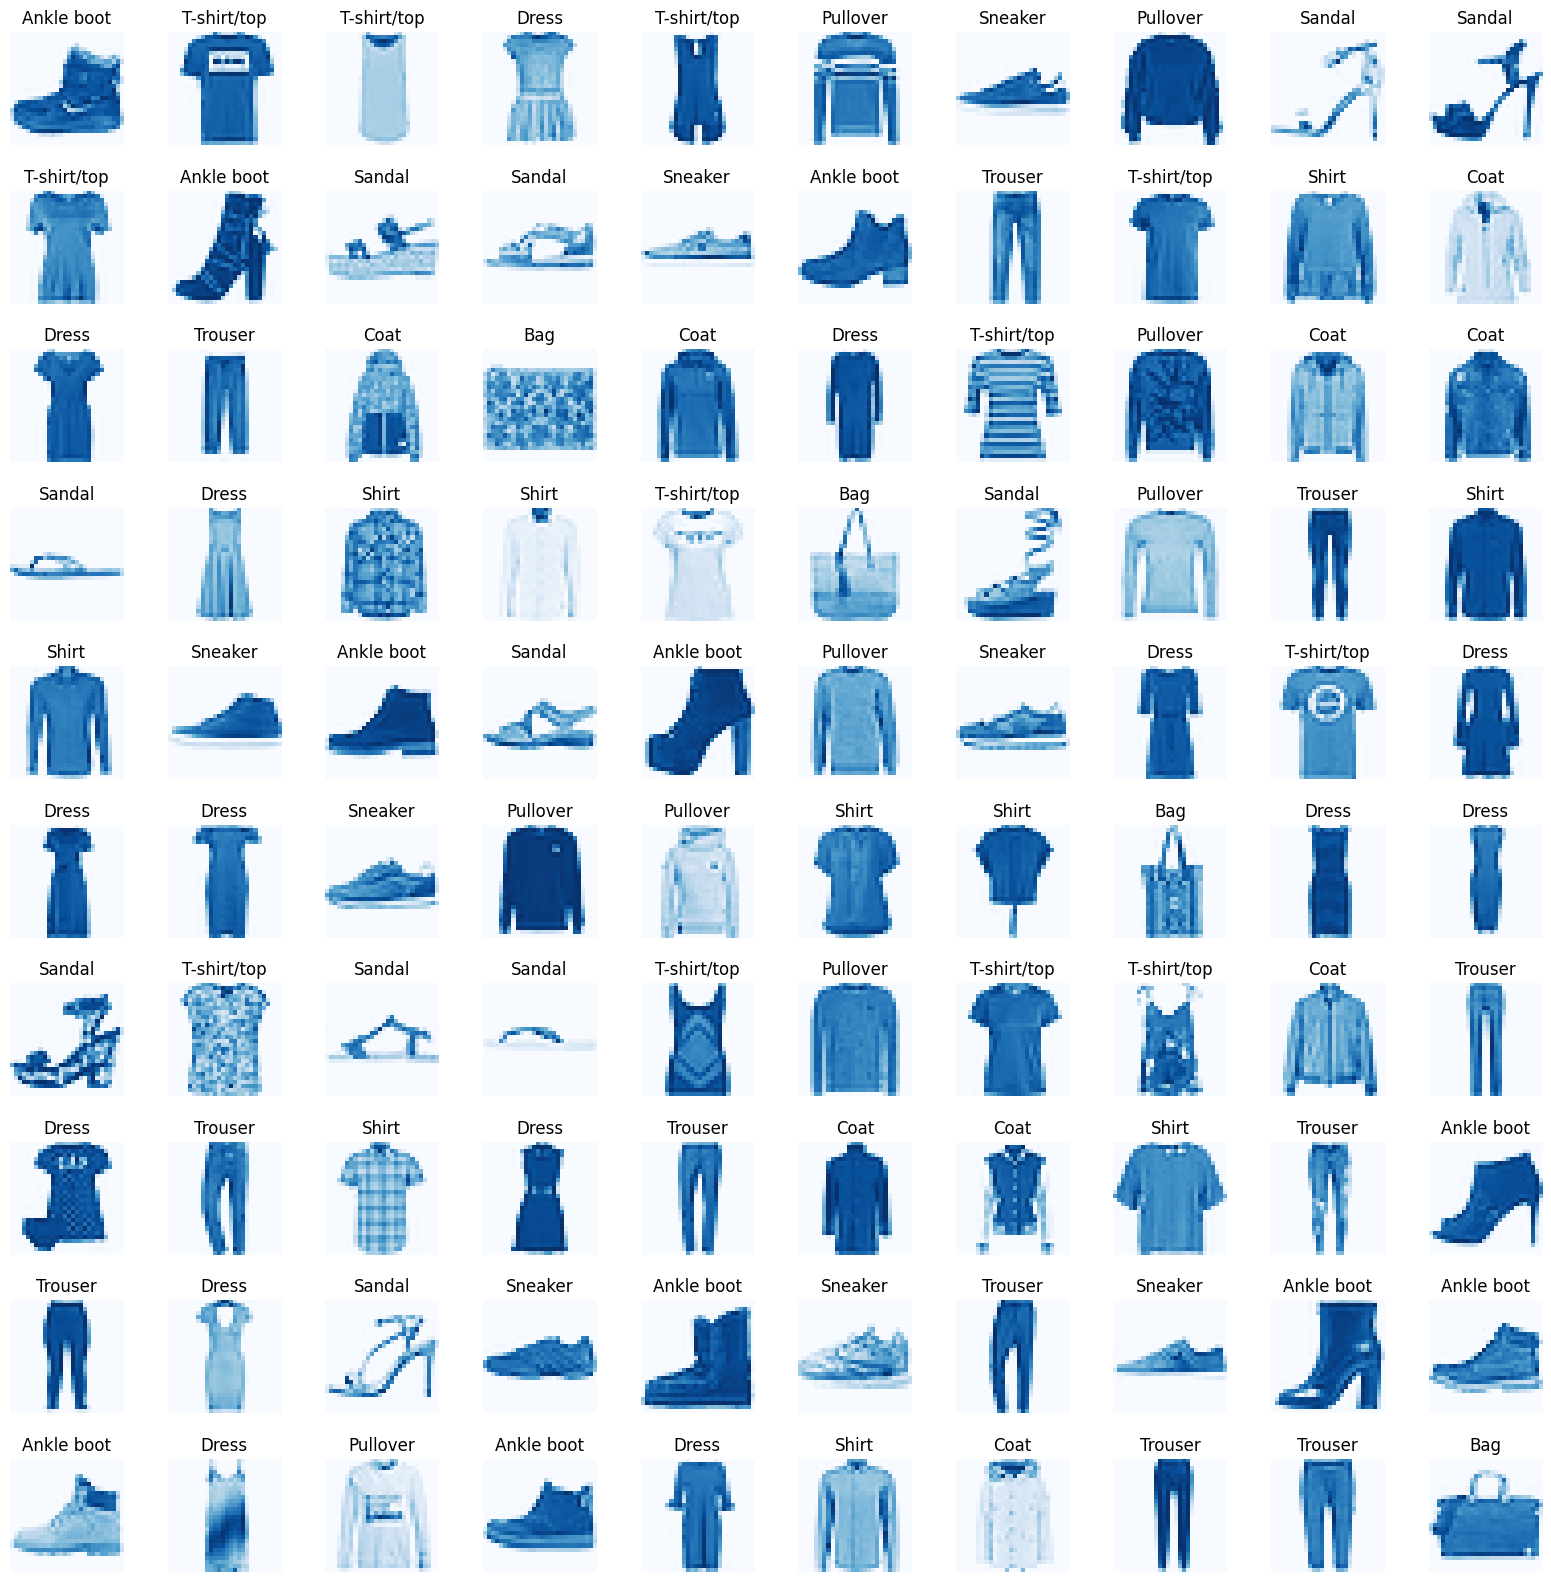

In [4]:
plot_images(train,train_label)

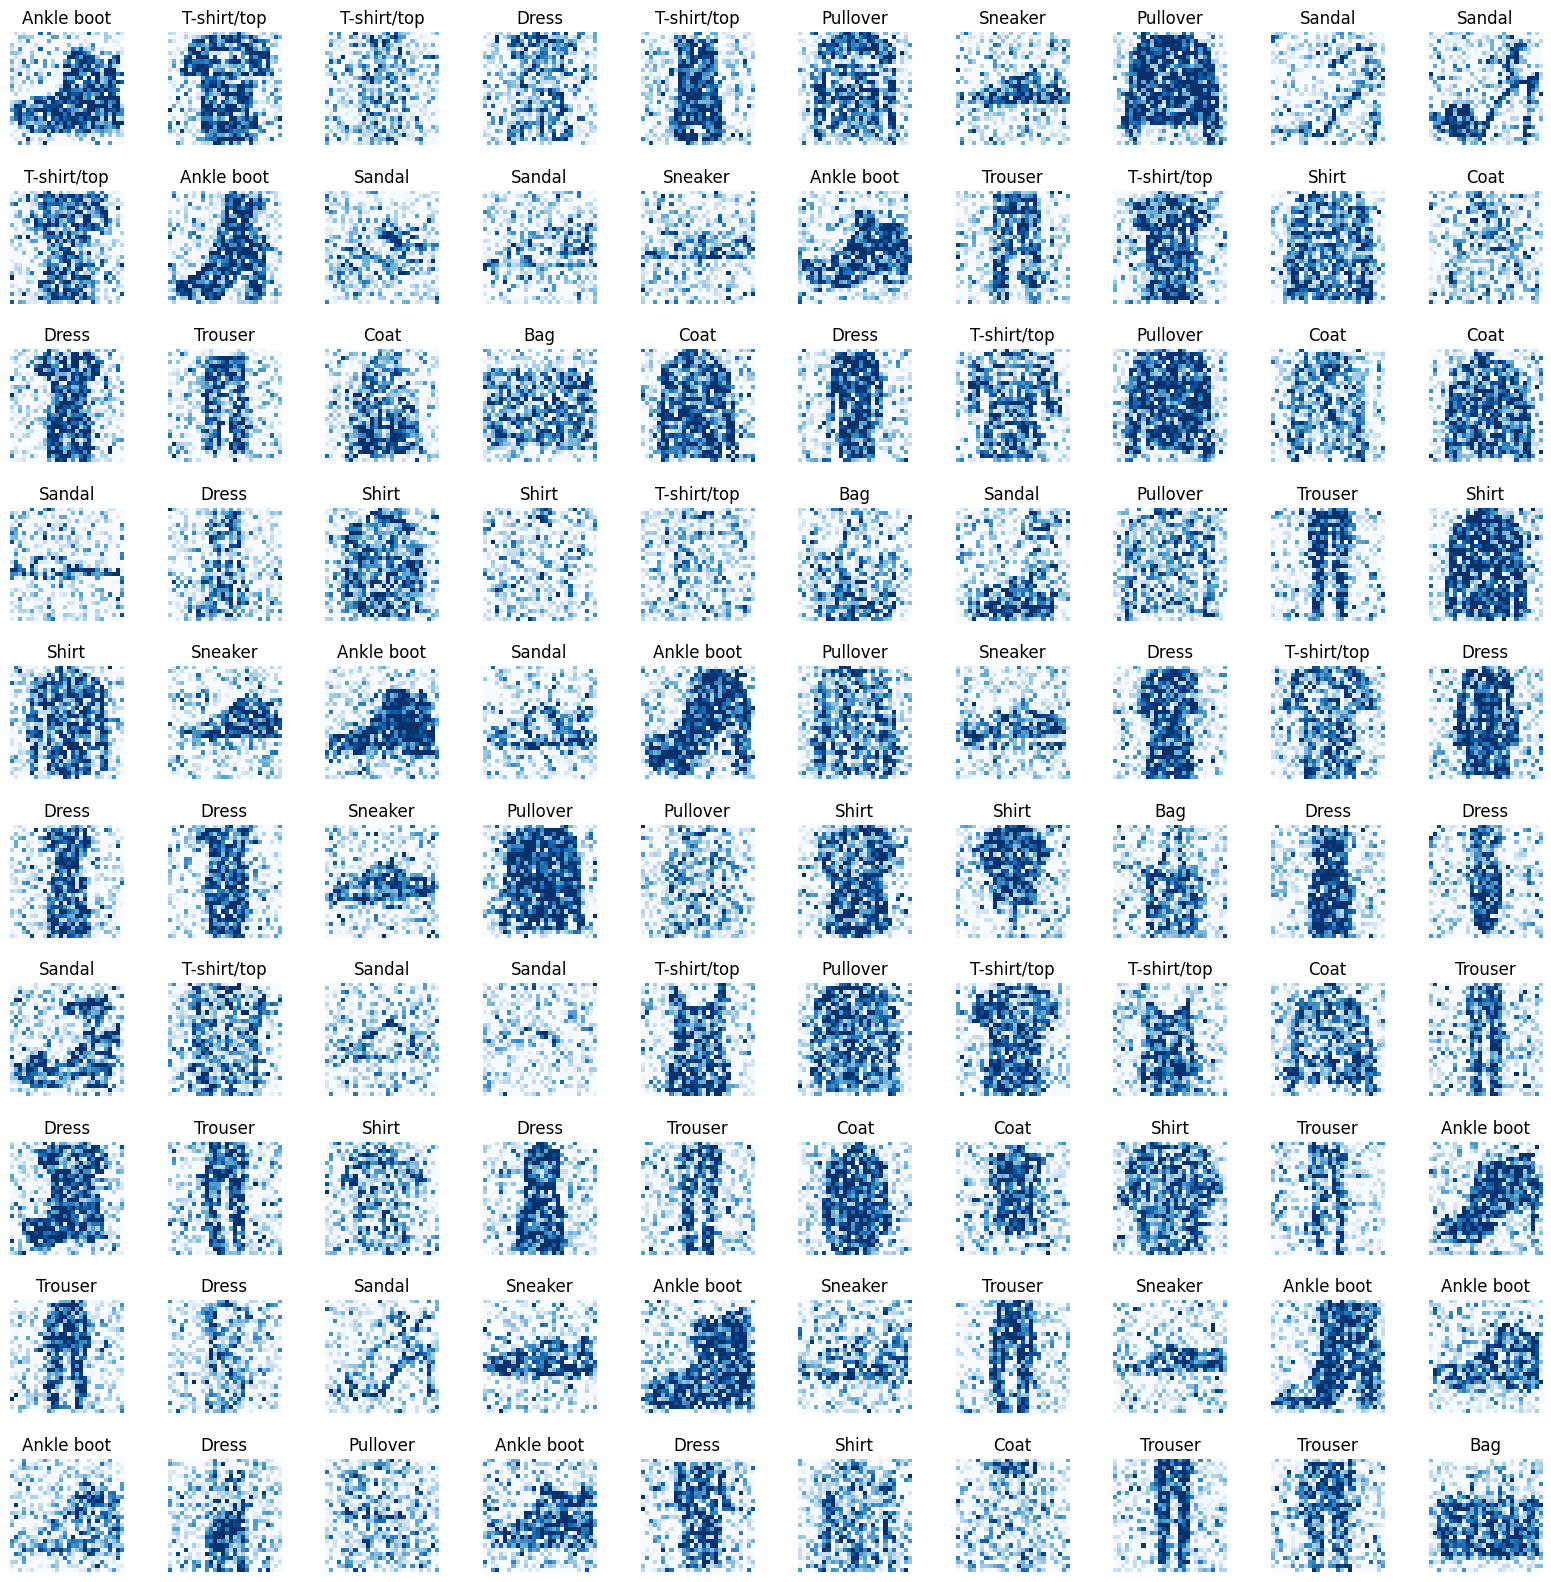

In [5]:
noise_factor = 0.4
noisy_train_images = np.clip(train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train.shape), 0, 1)
noisy_test_images = np.clip(test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test.shape), 0, 1)
plot_images(noisy_train_images,train_label)

In [6]:
#Кодирование
input_img=Input(shape=(28,28,1)) #исходный слой изображение
'''
Conv2D (свёрточный слой) - 128 фильтров с ядрами 7х7 пиксела каждый. Затем, параметр padding=’same’ означает,
что выходная карта признаков на каждом канале должна быть той же размерностью, что и исходное изображение
'''
x=Conv2D(128,(7,7),activation='relu',padding='same')(input_img)
'''
MaxPooling2D (вспомогательный слой) - укрупнять масштаб полученных признаков
'''
x=MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(1, (7, 7), activation='elu', padding='same')(x)

#Декоридрование
input_encoded = Input(shape=(7, 7, 1)) #исходный слой изображение
x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
'''
Каждый элемент карты признаков увеличивается до указанного размера (2, 2),
причем при масштабировании каждой ячейки (синяя рамка) значение просто копируется в соседние,
заполняя все свое пространство. И так каждый элемент.
'''
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

In [7]:
#изменяем размер изображений 28 на 28 в градации серого
reshaped_noisy_train_images = noisy_train_images.reshape((len(noisy_train_images), 28, 28, 1))
reshaped_train_images = train.reshape((len(train), 28, 28, 1))
reshaped_test_images = test.reshape((len(test), 28, 28, 1))
reshaped_noisy_test_images = noisy_test_images.reshape((len(noisy_test_images), 28, 28, 1))

In [8]:
# ранняя остановка работы нейросети с определением лучшего показателя
early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
encoder.summary()
decoder.summary()
autoencoder.summary()
'''
Оптимизация Адама — это метод стохастического градиентного спуска, основанный на адаптивной оценке моментов первого и второго порядка.
loss - вычисляет потерю кроссэнтропии между метками и прогнозами.
metrics accuracy - определяет точность модели
'''
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
'''
epochs - количество прогонов
batch_size - количество обучающих примеров за одну итерацию
'''
history = autoencoder.fit(reshaped_noisy_train_images, reshaped_train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(reshaped_noisy_test_images, reshaped_test_images),
                          callbacks=[early_stoping]).history

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       6400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 1)           1569

In [9]:
#оценка результатов работы
loss3,acc3 = autoencoder.evaluate(reshaped_noisy_test_images, reshaped_test_images,batch_size = 64, verbose = 0)
print('The accuracy of the Base Model is:',acc3*100)
print('The Loss of the Base Model is:',loss3)

The accuracy of the Base Model is: 50.57918429374695
The Loss of the Base Model is: 0.2852412462234497


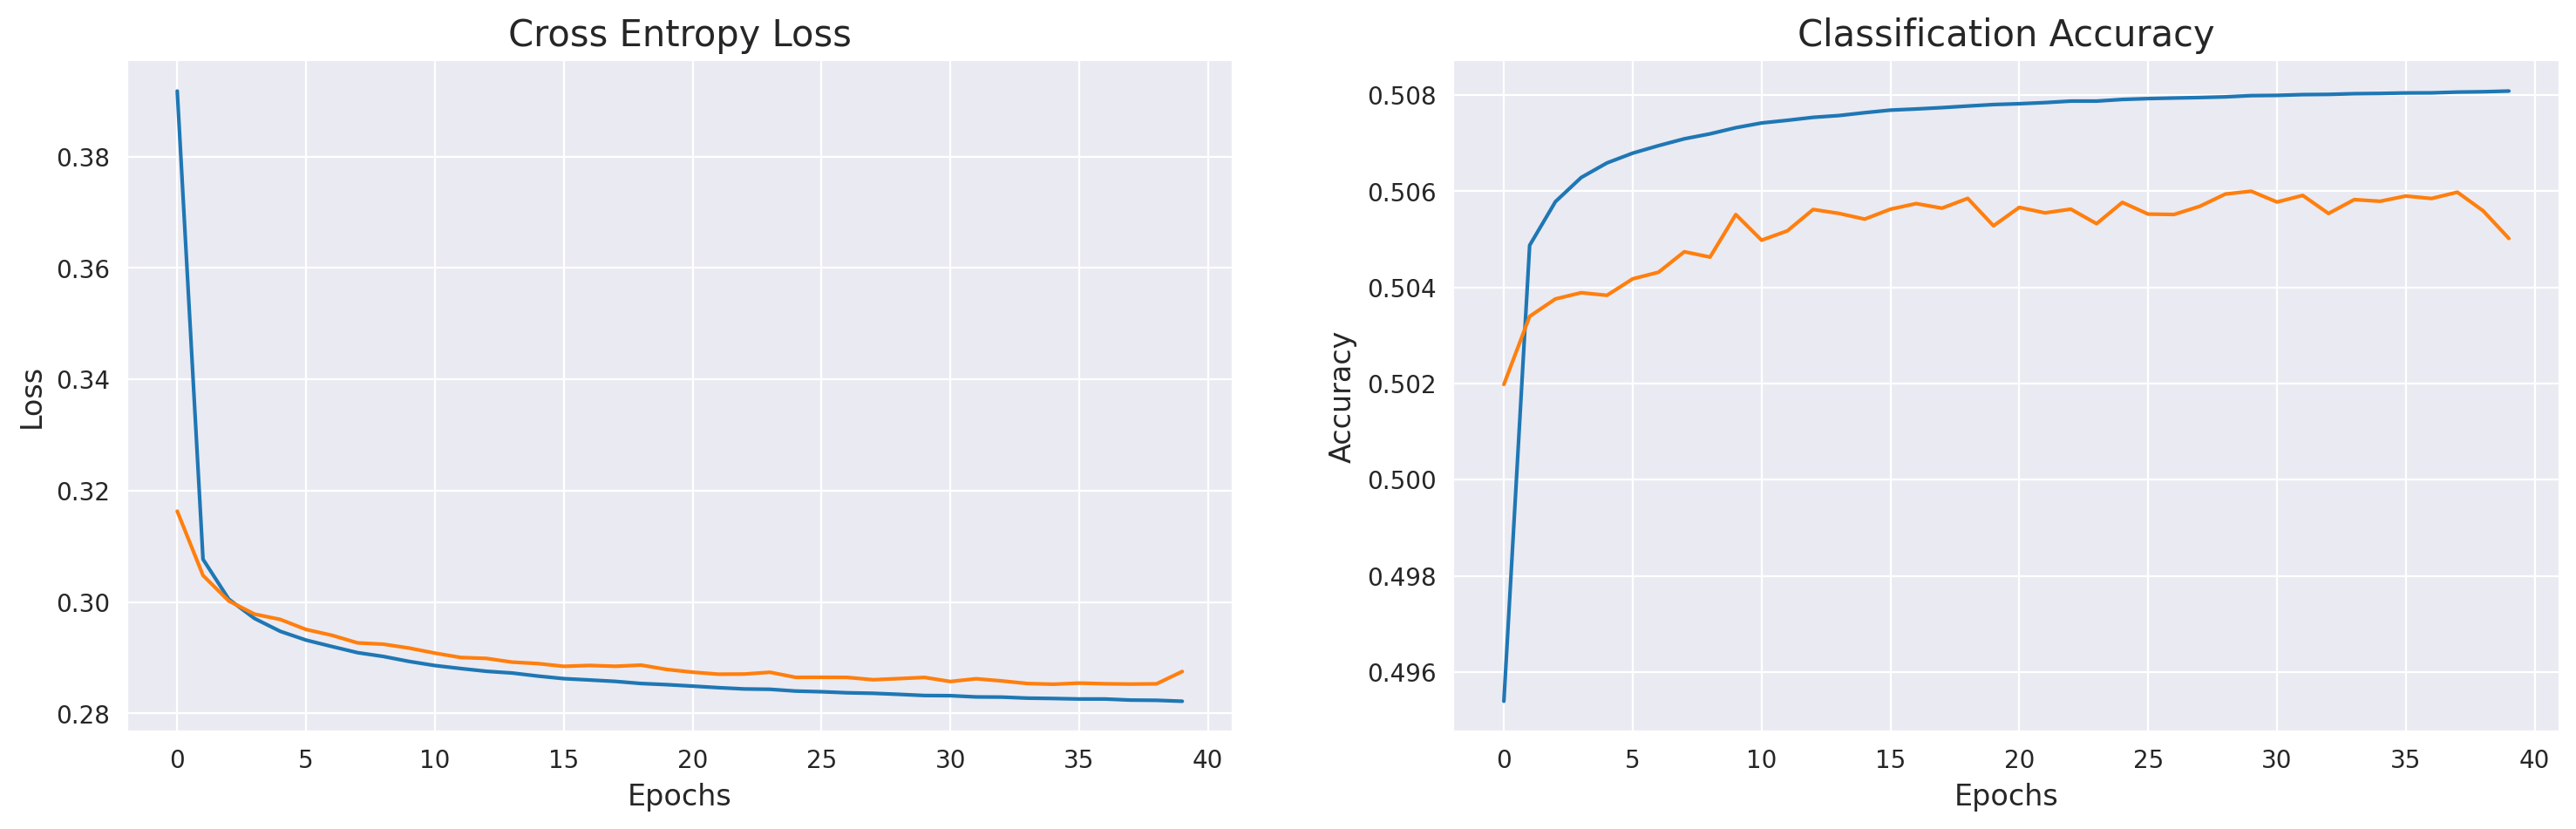

In [10]:
# построение графиков потерь и качества относительно итераций работы нейросети

error = pd.DataFrame(history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

Качество работы модели по показателям не является наилучшим, однако, учитывая тот факт, что изображения были с шумом (качество на минимуме), то такой результат является вполне допустимым.
**Окончательный итог будет подведен при анализе картинок!**

In [11]:
y_pred = autoencoder.predict(test)

313/313 [==============================] - 1s 2ms/step


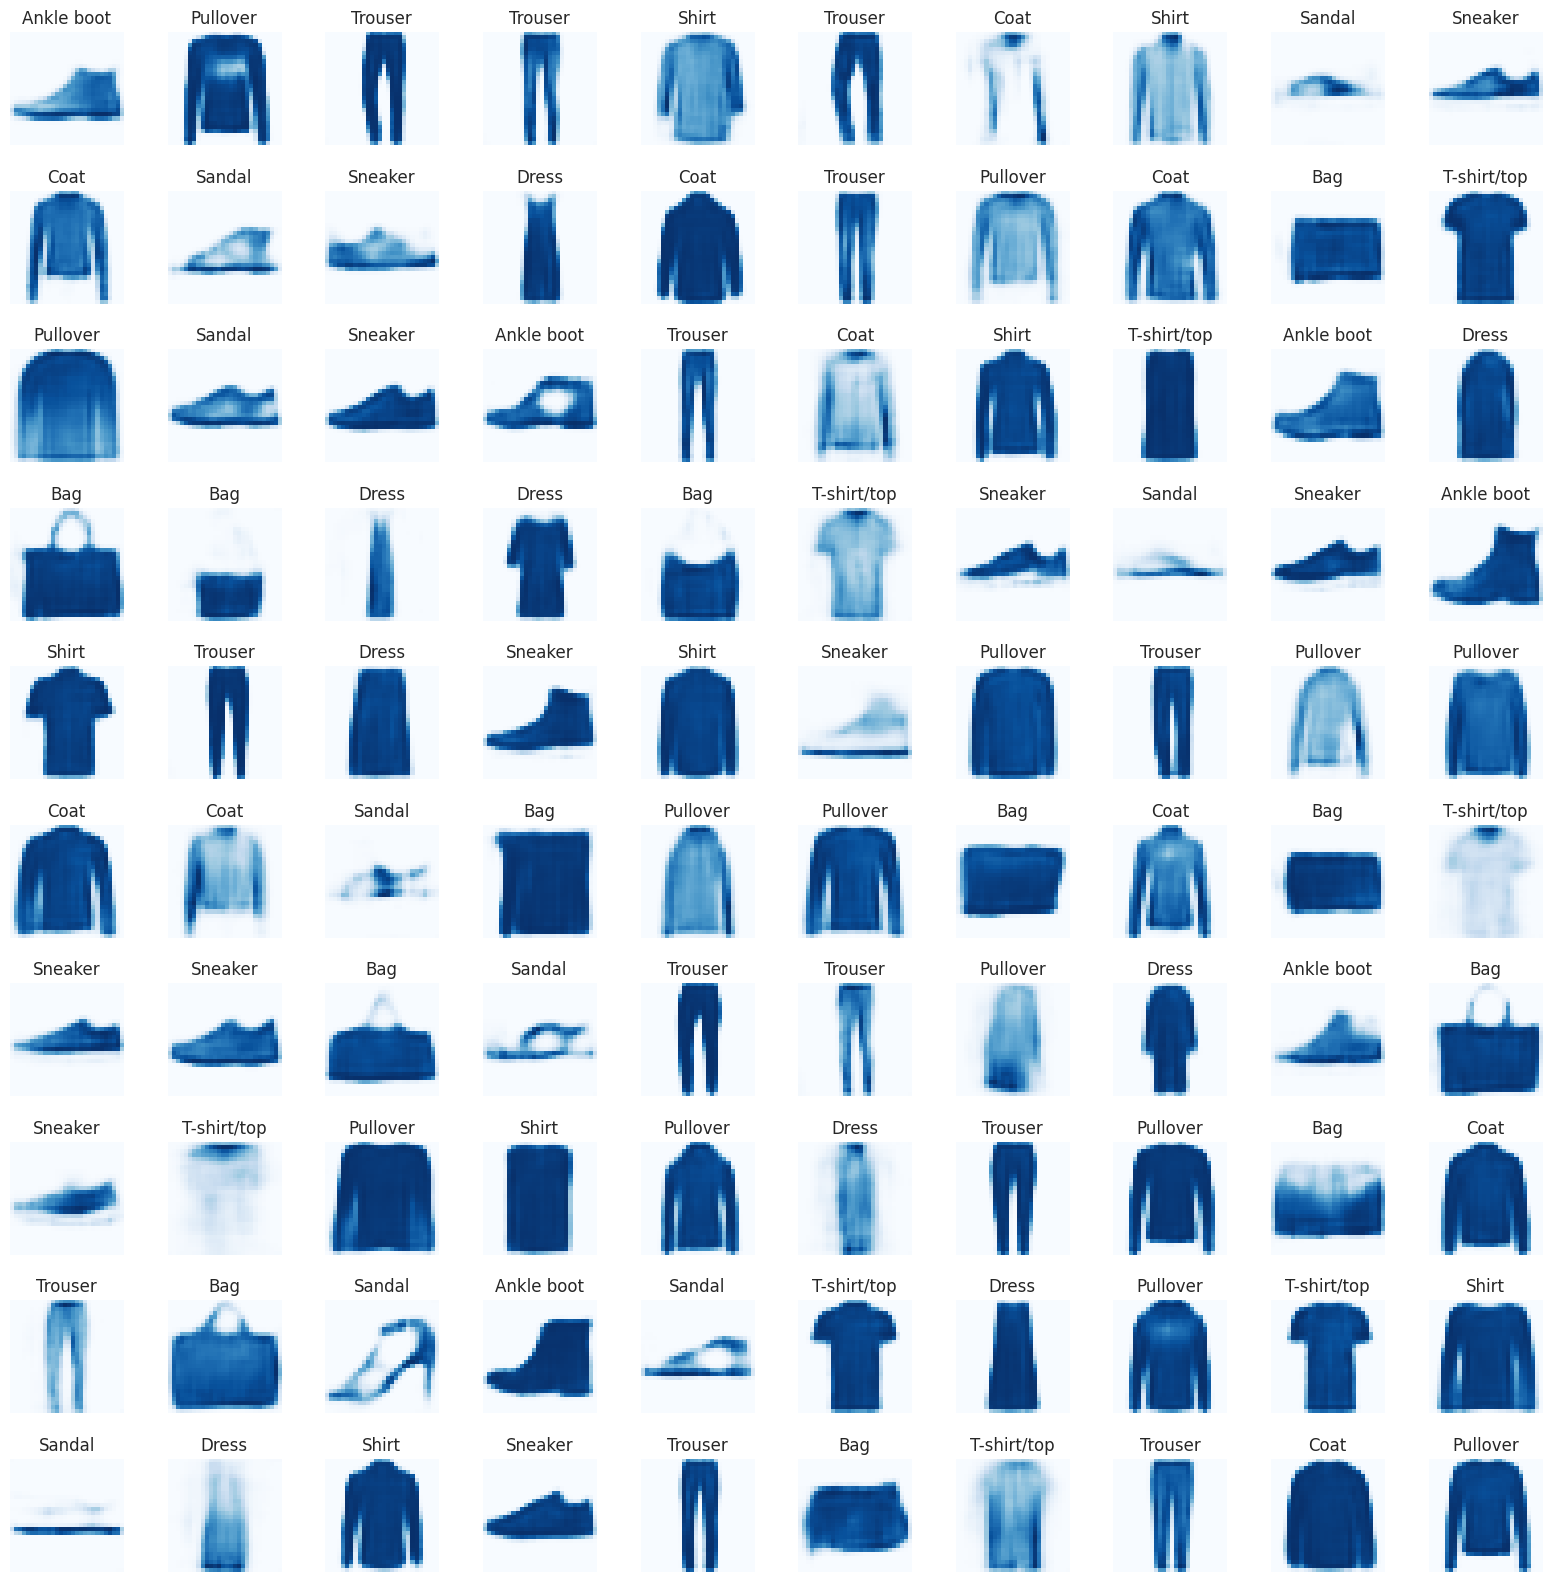

In [25]:
plot_images(y_pred,test_label)

ИТОГ: Проанализировав картинки, с уверенностью можно сказать, что 90% изображений близки к исходным. Очертания довольно чёткие и без особых трудностей можно понять какая вещь лежит на фото.
